## Base Models

In [2]:
# !pip install imblearn

In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath):
    """Loads and preprocesses MFCC data."""
    mfcc_df = pd.read_csv(classCSVPath)
    label_encoder = LabelEncoder()
    mfcc_df["Label"] = label_encoder.fit_transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels)

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels)
    return images, labels_one_hot


# def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram):
#     """Applies data augmentation and SMOTE to spectrogram data."""
#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )
#     datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

#     smote = SMOTE(random_state=37)
#     X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1) # Reshape for SMOTE
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
#     X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3) # Reshape back
#     y_train_resampled = to_categorical(y_train_resampled)

#     return X_train_resampled, y_train_resampled, datagen


# def apply_smote_mfcc(X_train_mfcc, y_train_mfcc):
#     """Applies SMOTE to MFCC data."""
#     smote = SMOTE(random_state=37)
#     X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1) # Reshape for SMOTE
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
#     X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
#     y_train_resampled = to_categorical(y_train_resampled)
#     return X_train_resampled, y_train_resampled

from collections import Counter

def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    unique_classes = np.unique(np.argmax(y_train_spectrogram, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
        X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)  # Reshape back
        y_train_resampled = to_categorical(y_train_resampled)
    else:
        print("Skipping SMOTE: Only one class detected in y_train_spectrogram.")
        X_train_resampled, y_train_resampled = X_train_spectrogram, y_train_spectrogram  # Use original data

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc):
    """Applies SMOTE to MFCC data."""
    unique_classes = np.unique(np.argmax(y_train_mfcc, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
        X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
        y_train_resampled = to_categorical(y_train_resampled)
    else:
        print("Skipping SMOTE: Only one class detected in y_train_mfcc.")
        X_train_resampled, y_train_resampled = X_train_mfcc, y_train_mfcc  # Use original data

    return X_train_resampled, y_train_resampled


def SplitDataset(classCSVPath):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


In [12]:
base_audio_path = r"C:\Users\HP\Downloads\Project\Dataset\base_audio_mfcc_features_with_labels.csv"

X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_spec, y_train_spec, X_test_spec, y_test_spec, label_encoder, datagen = SplitDataset(base_audio_path)

# Now you have access to datagen:
# Example usage:
# model.fit(datagen.flow(X_train_spec, y_train_spec, batch_size=32), ...) # Example

In [13]:
# Print sample output
print(f"Sample MFCC Features Shape: {X_test_mfcc.shape}")  # (samples, timesteps, features)
print(f"Sample Spectrogram Image Shape: {X_test_spec.shape}")  # (samples, 224, 224, 3)
print(f"Sample Label One-Hot: {y_test_mfcc[12]}")  # Example label
print(f"Sample Label One-Hot: {y_test_spec[12]}")  # Example label

Sample MFCC Features Shape: (144, 13, 1)
Sample Spectrogram Image Shape: (144, 224, 224, 3)
Sample Label One-Hot: [1. 0. 0. 0.]
Sample Label One-Hot: [1. 0. 0. 0.]


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Evaluation and Visualization
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, label_encoder, dataset_name):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print("Test Accuracy: ", accuracy_score(y_true, y_pred))
    print(f"Classification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.show()

## MFCC Models

### CNN Model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_mfcc.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer
])

cnn_model.summary()

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,244 (133.77 KB)

 Trainable params: 33,860 (132.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [38]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False) # Adjust patience as needed

# Train the model
history = cnn_model.fit(X_train_mfcc, y_train_mfcc, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping]) # Adjust epochs and batch size


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5509 - loss: 1.5986 - val_accuracy: 0.8235 - val_loss: 1.4285
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8684 - loss: 0.6463 - val_accuracy: 0.8676 - val_loss: 1.3827
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9131 - loss: 0.4529 - val_accuracy: 0.8235 - val_loss: 1.3467
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9296 - loss: 0.4826 - val_accuracy: 0.8382 - val_loss: 1.3125
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9495 - loss: 0.4161 - val_accuracy: 0.9118 - val_loss: 1.3082
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9283 - loss: 0.3707 - val_accuracy: 0.9412 - val_loss: 1.2860
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9771 - loss: 0.3055 - val_accuracy: 0.9118 - val_loss: 1.2599
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9702 - loss: 0.3290 - val_accuracy: 0.9118 - val_loss: 1.2320


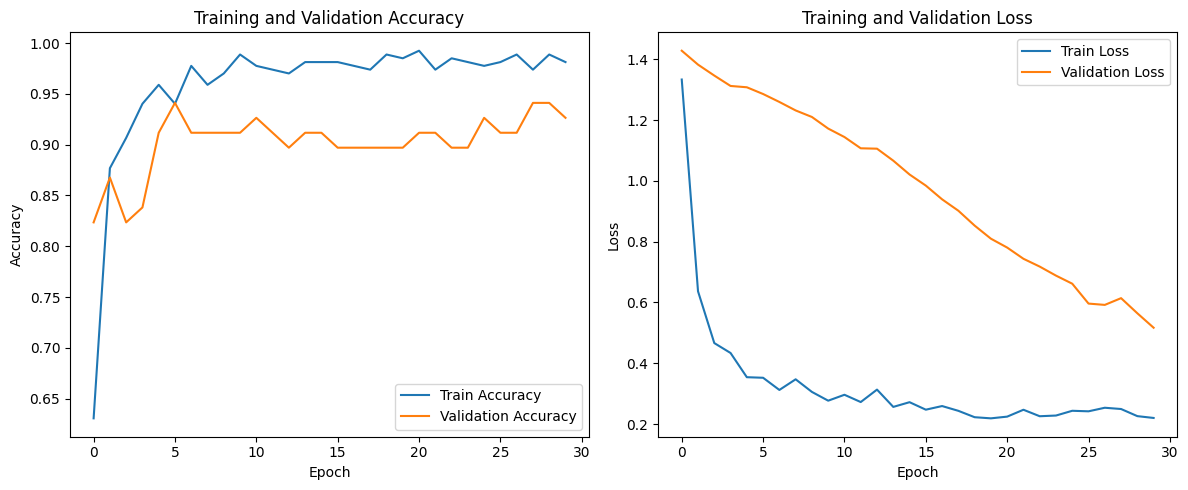

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test Accuracy:  0.9513888888888888
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       1.00      0.83      0.91        36
          MS       0.86      1.00      0.92        36
           N       1.00      0.97      0.99        36

    accuracy                           0.95       144
   macro avg       0.96      0.95      0.95       144
weighted avg       0.96      0.95      0.95       144



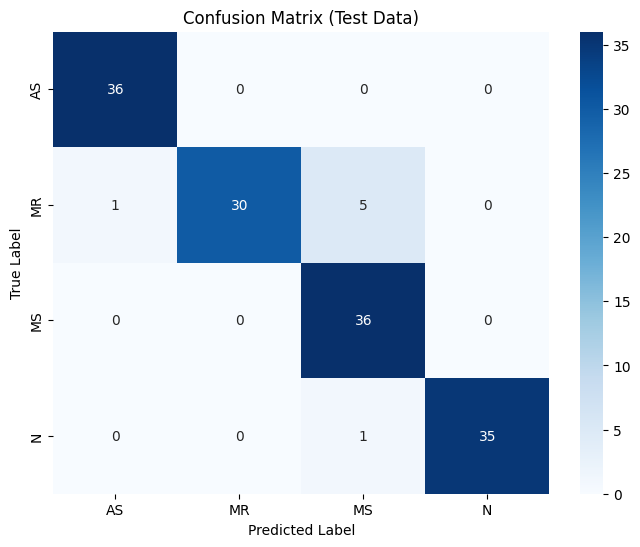

In [39]:
plot_training_history(history)

evaluate_model(cnn_model, X_test_mfcc, y_test_mfcc, label_encoder, "Test Data")

In [40]:
cnn_model.save('RedoneModels/mfcc_cnn.h5')

### LSTM

In [41]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_mfcc.shape[1], 1), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer with softmax activation
])
lstm_model.summary()

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 13, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,340 (212.27 KB)

 Trainable params: 54,340 (212.27 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False) 

history = lstm_model.fit(
    X_train_mfcc, y_train_mfcc, 
    epochs=30, 
    batch_size=32, 
    validation_split = 0.2,
    callbacks=[early_stopping,]
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.4241 - loss: 1.3556 - val_accuracy: 0.7794 - val_loss: 1.2460
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6545 - loss: 1.2172 - val_accuracy: 0.7794 - val_loss: 1.0020
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6276 - loss: 1.0402 - val_accuracy: 0.8235 - val_loss: 0.7699
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6784 - loss: 0.8593 - val_accuracy: 0.8088 - val_loss: 0.6428
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8211 - loss: 0.6475 - val_accuracy: 0.8235 - val_loss: 0.5903
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8382 - loss: 0.5242 - val_accuracy: 0.8382 - val_loss: 0.5369
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9108 - loss: 0.4276 - val_accuracy: 0.9265 - val_loss: 0.4323
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8934 - loss: 0.3972 - val_accuracy: 0.8676 - val_loss: 0.4311


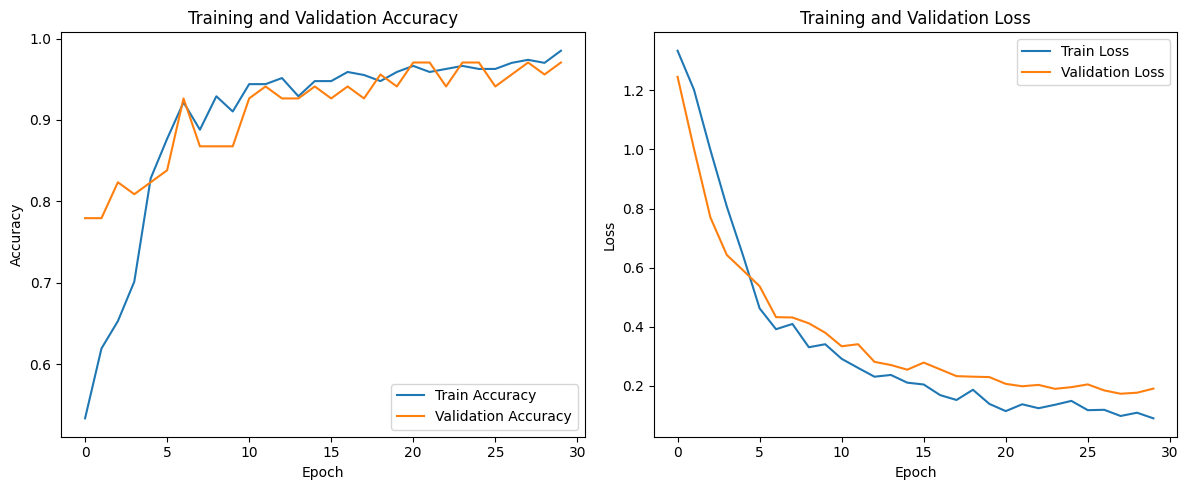

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Test Accuracy:  0.9861111111111112
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       0.97      1.00      0.99        36
          MS       1.00      0.94      0.97        36
           N       1.00      1.00      1.00        36

    accuracy                           0.99       144
   macro avg       0.99      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144



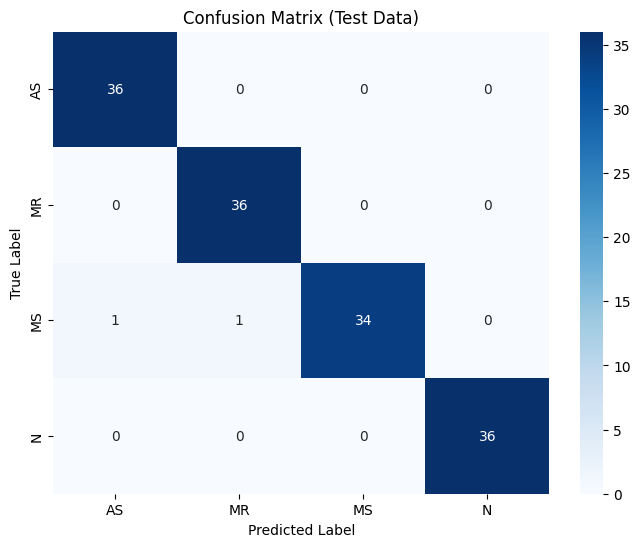

In [44]:
plot_training_history(history)

evaluate_model(lstm_model, X_test_mfcc, y_test_mfcc, label_encoder, "Test Data")

In [45]:
lstm_model.save("RedoneModels/mfcc_lstm.h5")

### BiLSTM

In [46]:
from tensorflow.keras.layers import Bidirectional

In [47]:
# BiLSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_mfcc.shape[1], 1)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_mfcc.shape[1], activation='softmax')  # Output layer with softmax activation
])
bilstm_model.summary()

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 13, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,124 (551.27 KB)

 Trainable params: 141,124 (551.27 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False) 

history = bilstm_model.fit(
    X_train_mfcc, y_train_mfcc, 
    epochs=30, 
    batch_size=32, 
    validation_split = 0.2,
    callbacks=[early_stopping,]
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.4628 - loss: 1.3343 - val_accuracy: 0.8235 - val_loss: 1.1197
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7110 - loss: 1.0700 - val_accuracy: 0.7941 - val_loss: 0.7679
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7352 - loss: 0.7316 - val_accuracy: 0.7206 - val_loss: 0.7755
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8031 - loss: 0.6071 - val_accuracy: 0.8235 - val_loss: 0.5882
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8337 - loss: 0.5205 - val_accuracy: 0.8382 - val_loss: 0.4930
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8382 - loss: 0.4402 - val_accuracy: 0.8676 - val_loss: 0.4220
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9103 - loss: 0.3264 - val_accuracy: 0.8676 - val_loss: 0.4109
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9129 - loss: 0.3234 - val_accuracy: 0.9265 - val_loss: 0.2930


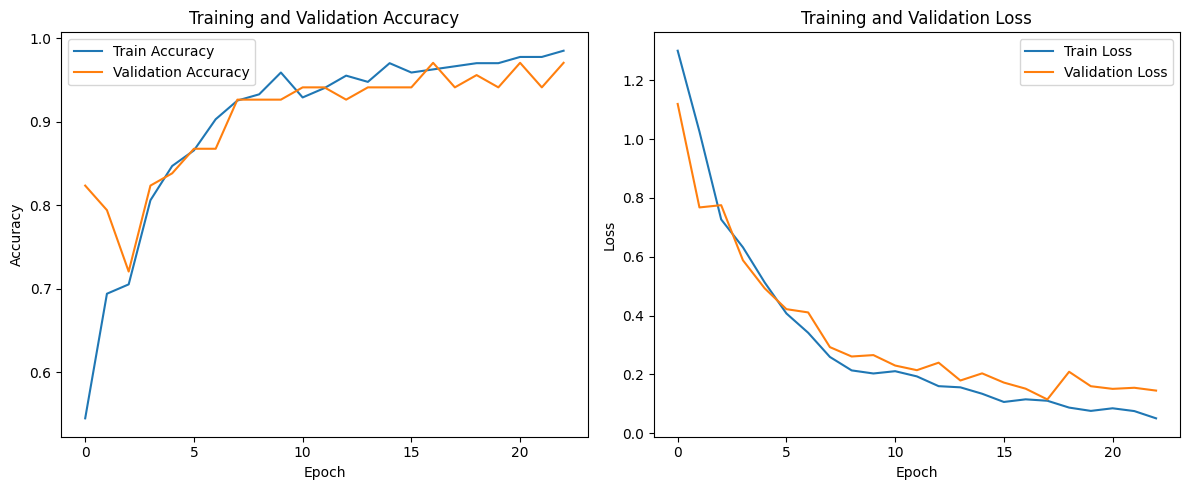

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Test Accuracy:  0.9652777777777778
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        36
          MR       0.88      1.00      0.94        36
          MS       1.00      0.89      0.94        36
           N       1.00      0.97      0.99        36

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



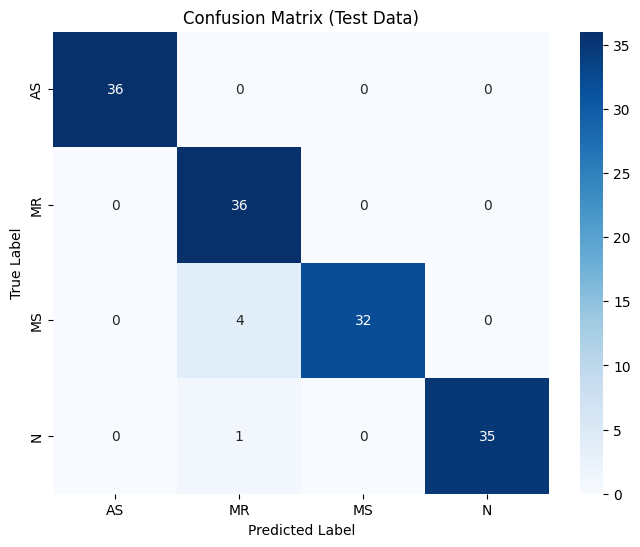

In [49]:
plot_training_history(history)

evaluate_model(bilstm_model, X_test_mfcc, y_test_mfcc, label_encoder, "Test Data")

In [50]:
bilstm_model.save("RedoneModels/mfcc_bilstm.h5")

### Random Forest


Random Forest Accuracy: 0.9930555555555556
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      1.00      0.99        36
           2       1.00      1.00      1.00        36
           3       1.00      0.97      0.99        36

    accuracy                           0.99       144
   macro avg       0.99      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144



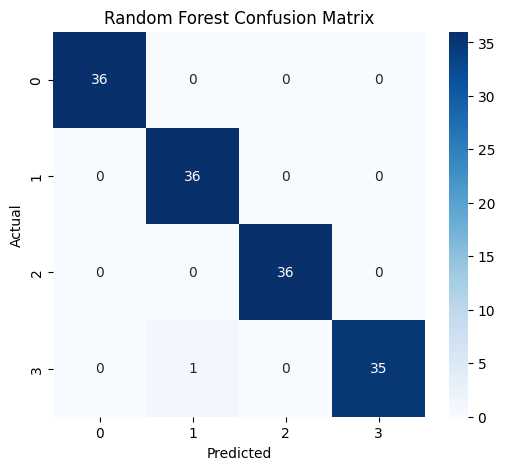

Model saved at RedoneModels/mfcc_rf.pkl


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Function to plot confusion matrix heatmap
def plot_heatmap(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Train and save the Random Forest model
def train_and_save_random_forest(X_train, y_train, X_test, y_test, save_path):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train.argmax(axis=1))
    y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))

    print("Random Forest Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred))
    print(classification_report(y_test.argmax(axis=1), y_pred))
    plot_heatmap(y_test.argmax(axis=1), y_pred, "Random Forest Confusion Matrix")

    # Save the trained model
    joblib.dump(rf, save_path)
    print(f"Model saved at {save_path}")

# Call function to train and save the model
train_and_save_random_forest(X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, "RedoneModels/mfcc_rf.pkl")



### Decision Trees

Decision Tree Accuracy: 0.9652777777777778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.90      0.97      0.93        36
           2       0.97      0.92      0.94        36
           3       1.00      0.97      0.99        36

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



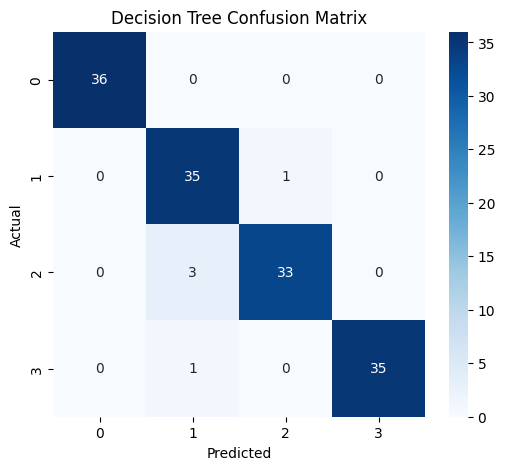

Model saved at RedoneModels/mfcc_dt.pkl


In [53]:
from sklearn.tree import DecisionTreeClassifier

# Train, evaluate, and save Decision Tree for MFCC
def train_and_save_decision_tree(X_train, y_train, X_test, y_test, save_path):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train.reshape(X_train.shape[0], -1), y_train.argmax(axis=1))
    y_pred = dt.predict(X_test.reshape(X_test.shape[0], -1))

    print("Decision Tree Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred))
    print(classification_report(y_test.argmax(axis=1), y_pred))
    plot_heatmap(y_test.argmax(axis=1), y_pred, "Decision Tree Confusion Matrix")

    # Save the trained model
    joblib.dump(dt, save_path)
    print(f"Model saved at {save_path}")

# Call function to train and save the model
train_and_save_decision_tree(X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, "RedoneModels/mfcc_dt.pkl")


## Spectrogram

In [54]:
import tensorflow as tf
X_train_np = np.array(X_train_spec)
y_train_np = np.array(y_train_spec)

# Calculate the number of samples for validation
num_val_samples = int(0.2 * len(X_train_np))

# Randomly shuffle the training data
indices = np.arange(len(X_train_np))
np.random.shuffle(indices)
X_train_np = X_train_np[indices]
y_train_np = y_train_np[indices]

# Split into training and validation sets
X_train_actual = X_train_np[num_val_samples:]
y_train_actual = y_train_np[num_val_samples:]
X_val = X_train_np[:num_val_samples]
y_val = y_train_np[:num_val_samples]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_actual, y_train_actual))
train_dataset = train_dataset.batch(32).repeat()

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))  # Use test set as validation set
validation_dataset = validation_dataset.batch(32)

### MobileNet

In [55]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

In [56]:
# MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Load pre-trained MobileNetV2 (without the top classification layer)

# Freeze the base model's layers (optional, but often a good idea initially)
base_model.trainable = False

# Add custom classification head on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) # Global average pooling to reduce to 1D
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x) # L2 regularization
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x) # L2 regularization
x = Dropout(0.5)(x)
predictions = Dense(y_train_spec.shape[1], activation='softmax')(x) # Output layer

# Create the final model
mobile_net_model = Model(inputs=base_model.input, outputs=predictions)

# mobile_net_model.summary()

In [59]:
mobile_net_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False) 

history = mobile_net_model.fit(
    train_dataset,  # Use data augmentation
    epochs=30, 
    steps_per_epoch=len(X_train_spec) // 32, # Number of batches per epoch
    validation_data=validation_dataset, # Use test data for validation
    callbacks=[early_stopping]
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step - accuracy: 0.9677 - loss: 0.4915 - val_accuracy: 0.9552 - val_loss: 0.4450
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 470ms/step - accuracy: 0.9880 - loss: 0.3406 - val_accuracy: 0.9851 - val_loss: 0.3163
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.9942 - loss: 0.3022 - val_accuracy: 0.9701 - val_loss: 0.3242
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.9872 - loss: 0.2777 - val_accuracy: 0.9851 - val_loss: 0.2606
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.9963 - loss: 0.2565 - val_accuracy: 0.9851 - val_loss: 0.2756
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.9935 - loss: 0.2728 - val_accuracy: 0.9851 - val_loss: 0.2587
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.9744 - loss: 0.3417 - val_accuracy: 0.9701 - val_loss: 0.2949
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.9901 - loss: 0.2663 - val_accuracy: 0

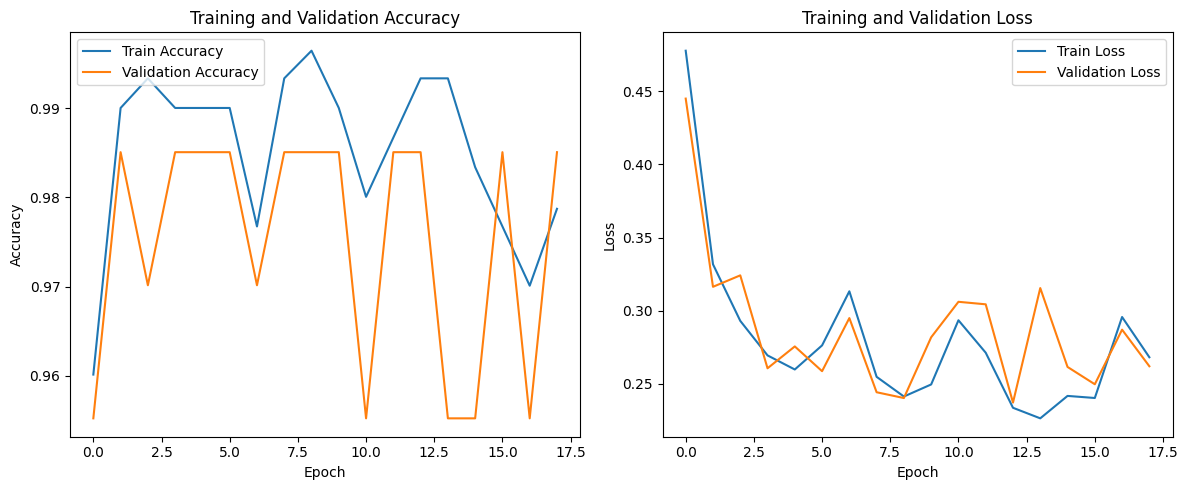

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step
Test Accuracy:  1.0
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        36
          MR       1.00      1.00      1.00        36
          MS       1.00      1.00      1.00        36
           N       1.00      1.00      1.00        36

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144



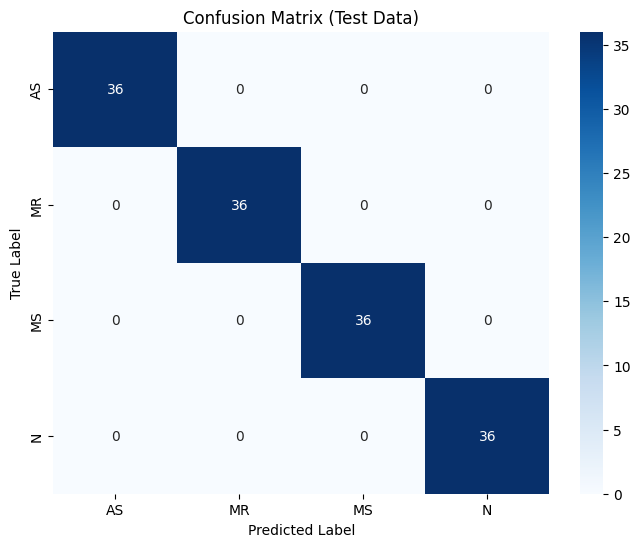

In [60]:
plot_training_history(history)

evaluate_model(mobile_net_model, X_test_spec, y_test_spec, label_encoder, "Test Data")

In [61]:
mobile_net_model.save("RedoneModels/spec_mbnet.h5")

### ResNet 

In [62]:
from tensorflow.keras.applications import ResNet50V2  # Import ResNet50V2

In [63]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x) # L2 regularization
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x) # L2 regularization
x = Dropout(0.5)(x)
predictions = Dense(y_train_spec.shape[1], activation='softmax')(x)

# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# resnet_model.summary()

In [64]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False) 

history = resnet_model.fit(
    train_dataset,  # Use data augmentation
    epochs=30, 
    steps_per_epoch=len(X_train_spec) // 32, # Number of batches per epoch
    validation_data=validation_dataset, # Use test data for validation
    callbacks=[early_stopping]
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 976ms/step - accuracy: 0.3976 - loss: 3.8980 - val_accuracy: 0.7164 - val_loss: 2.2349
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 959ms/step - accuracy: 0.6371 - loss: 2.2775 - val_accuracy: 0.9403 - val_loss: 1.4535
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8019 - loss: 1.6571 - val_accuracy: 0.8955 - val_loss: 1.3800
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7946 - loss: 1.5080 - val_accuracy: 0.9104 - val_loss: 1.1544
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9358 - loss: 1.1298 - val_accuracy: 0.9552 - val_loss: 1.0004
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9609 - loss: 1.0297 - val_accuracy: 0.9851 - val_loss: 0.9015
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9561 - loss: 0.9301 - val_accuracy: 0.9701 - val_loss: 0.8699
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9931 - loss: 0.8520 - val_accuracy: 0.9552 - val_

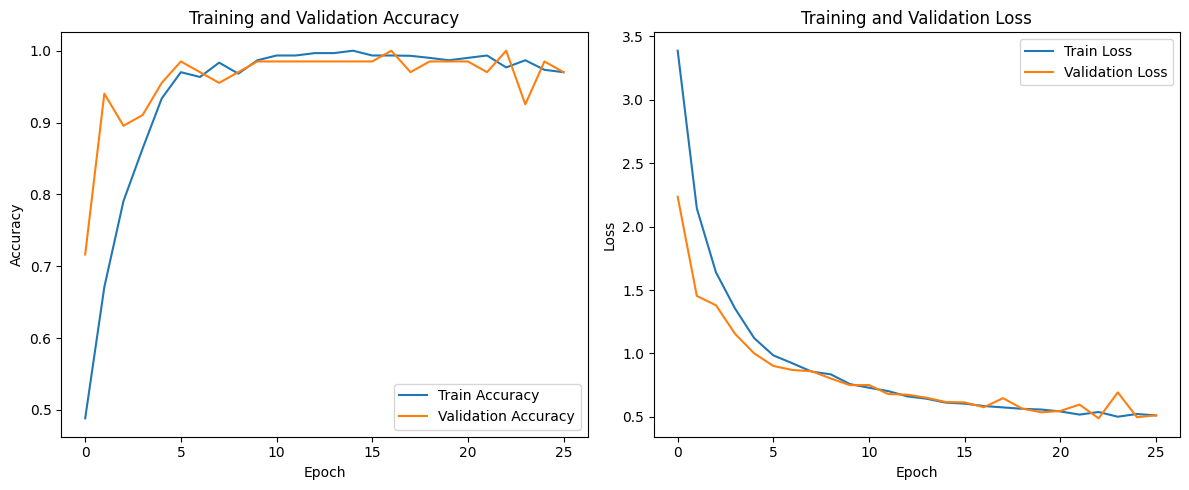

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 881ms/step
Test Accuracy:  0.9652777777777778
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       1.00      0.94      0.97        36
          MR       0.90      0.97      0.93        36
          MS       0.97      0.94      0.96        36
           N       1.00      1.00      1.00        36

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



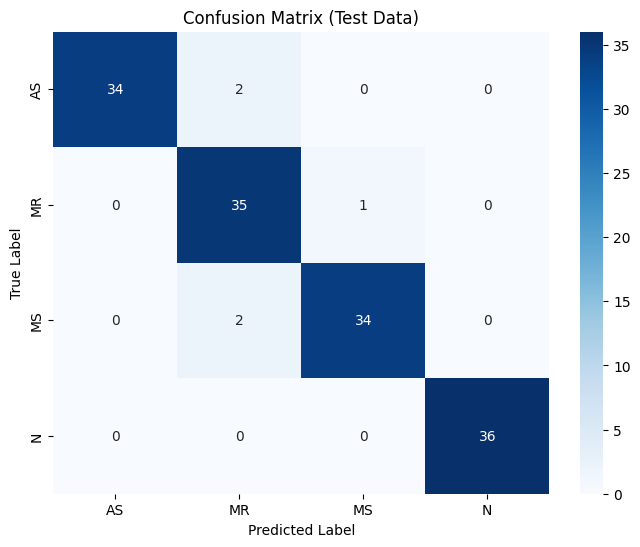

In [65]:
plot_training_history(history)

evaluate_model(resnet_model, X_test_spec, y_test_spec, label_encoder, "Test Data")

In [66]:
mobile_net_model.save("RedoneModels/spec_resnet.h5")

### RNN 


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Reshape input data for LSTM (Flatten spectrogram images)
X_train_spec_reshaped = X_train_spec.reshape(X_train_spec.shape[0], X_train_spec.shape[1] * X_train_spec.shape[2], X_train_spec.shape[3])
X_test_spec_reshaped = X_test_spec.reshape(X_test_spec.shape[0], X_test_spec.shape[1] * X_test_spec.shape[2], X_test_spec.shape[3])

# Build and train RNN model for Spectrogram
def build_rnn_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Training with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build Model
rnn_model = build_rnn_model(X_train_spec_reshaped.shape[1:], y_train_spec.shape[1])

# Train Model
history = rnn_model.fit(
    X_train_spec_reshaped, y_train_spec,
    epochs=1, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Plot Training History
plot_training_history(history)

# Evaluate Model
evaluate_model(rnn_model, X_test_spec_reshaped, y_test_spec, label_encoder, "Test Data")

# Save Model
rnn_model.save("RedoneModels/spec_rnn.h5")
print("Model saved at RedoneModels/spec_rnn.h5")


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### CNN

Epoch 1/30


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 822ms/step - accuracy: 0.3347 - loss: 58.4415 - val_accuracy: 0.3676 - val_loss: 1.6890
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 924ms/step - accuracy: 0.5627 - loss: 8.3406 - val_accuracy: 0.1029 - val_loss: 7.2455
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 962ms/step - accuracy: 0.7883 - loss: 3.0491 - val_accuracy: 0.1176 - val_loss: 24.9832
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 970ms/step - accuracy: 0.8285 - loss: 1.5227 - val_accuracy: 0.1176 - val_loss: 16.7712
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 960ms/step - accuracy: 0.8573 - loss: 1.1306 - val_accuracy: 0.1176 - val_loss: 13.7490
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8175 - loss: 1.1491 - val_accuracy: 0.1176 - val_loss: 13.1707
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 973ms/step - accuracy: 0.8947 - loss: 0.9268 - val_accuracy: 0.1176 - val_loss: 11.6543
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 969ms/step - accuracy: 0.8468 - loss: 1.0053 - val_accuracy: 0.1471 - val_loss: 11.742

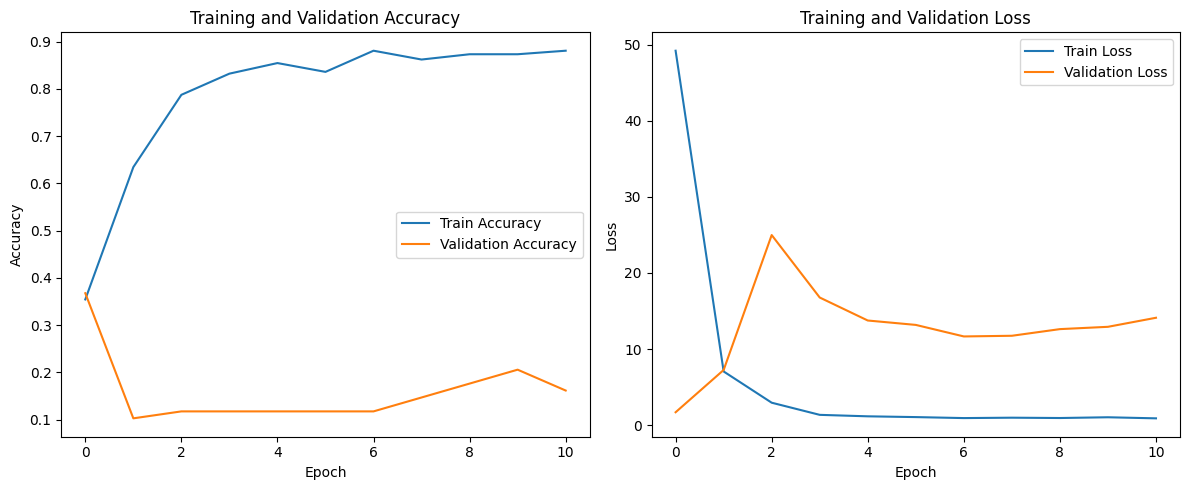

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
Test Accuracy:  0.4513888888888889
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       0.32      1.00      0.49        36
          MR       0.00      0.00      0.00        36
          MS       0.88      0.81      0.84        36
           N       0.00      0.00      0.00        36

    accuracy                           0.45       144
   macro avg       0.30      0.45      0.33       144
weighted avg       0.30      0.45      0.33       144



C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

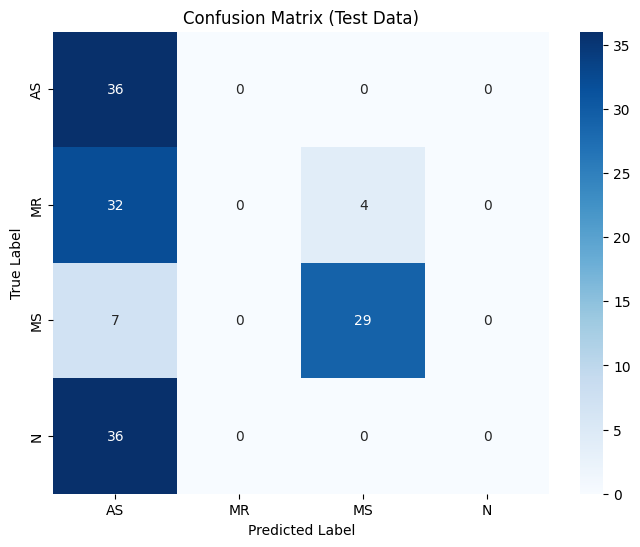

Model saved at RedoneModels/spectrogram_cnn.h5


In [68]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Build and train CNN model for Spectrogram using 2D Conv
def build_cnn_spectrogram_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(128, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Training with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn_spectrogram_model = build_cnn_spectrogram_model(X_train_spec.shape[1:], y_train_spec.shape[1])
history = cnn_spectrogram_model.fit(
    X_train_spec, y_train_spec,
    epochs=30, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Plot Training History
plot_training_history(history)

# Evaluate Model
evaluate_model(cnn_spectrogram_model, X_test_spec, y_test_spec, label_encoder, "Test Data")

# Save Model
cnn_spectrogram_model.save("RedoneModels/spectrogram_cnn.h5")
print("Model saved at RedoneModels/spectrogram_cnn.h5")


### EfficientNet

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 615ms/step - accuracy: 0.2928 - loss: 10.9611 - val_accuracy: 0.1176 - val_loss: 1.9711
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - accuracy: 0.2304 - loss: 1.9727 - val_accuracy: 0.2059 - val_loss: 1.3865
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.2889 - loss: 1.5033 - val_accuracy: 0.2059 - val_loss: 1.3870
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.2858 - loss: 1.3860 - val_accuracy: 0.2059 - val_loss: 1.3876
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - accuracy: 0.2318 - loss: 1.3862 - val_accuracy: 0.2059 - val_loss: 1.3883
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.2302 - loss: 1.3858 - val_accuracy: 0.2059 - val_loss: 1.3891
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 490ms/step - accuracy: 0.2484 - loss: 1.3864 - val_accuracy: 0.2059 - val_loss: 1.3895
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 0.2549 - loss: 1.3856 - val_accuracy: 0.2059 - val_los

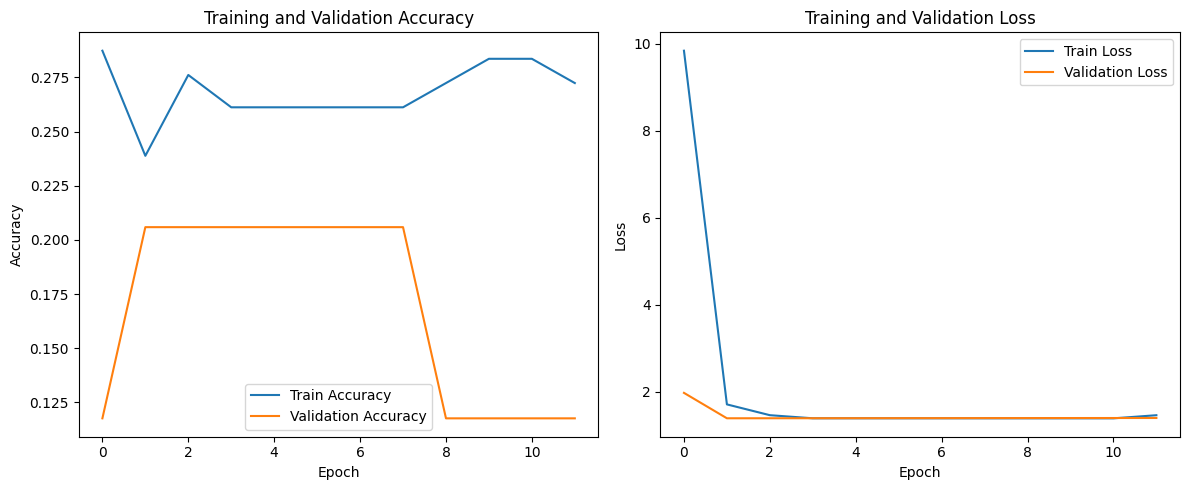

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023584F6B9C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 640ms/step
Test Accuracy:  0.25
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       0.00      0.00      0.00        36
          MR       0.00      0.00      0.00        36
          MS       0.00      0.00      0.00        36
           N       0.25      1.00      0.40        36

    accuracy                           0.25       144
   macro avg       0.06      0.25      0.10       144
weighted avg       0.06      0.25      0.10       144



C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

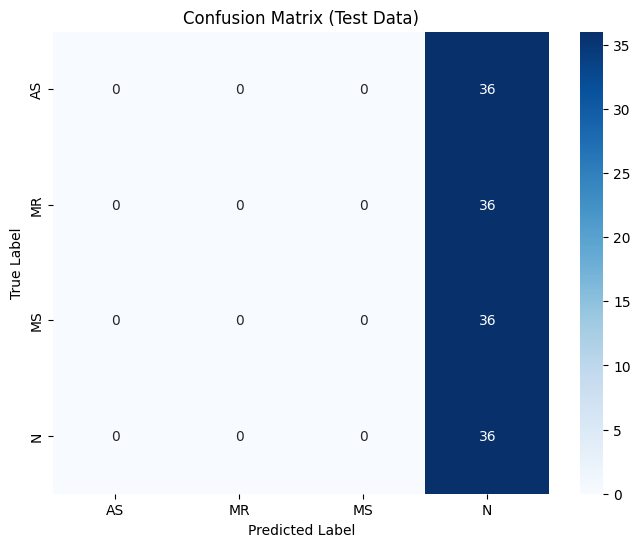

Model saved at RedoneModels/spectrogram_efficientnet.h5


In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

# Build and train EfficientNet model for Spectrogram
def build_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freezing pre-trained layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Training with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

efficientnet_model = build_efficientnet_model(X_train_spec.shape[1:], y_train_spec.shape[1])
history = efficientnet_model.fit(
    X_train_spec, y_train_spec,
    epochs=30, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Plot Training History
plot_training_history(history)

# Evaluate Model
evaluate_model(efficientnet_model, X_test_spec, y_test_spec, label_encoder, "Test Data")

# Save Model
efficientnet_model.save("RedoneModels/spectrogram_efficientnet.h5")
print("Model saved at RedoneModels/spectrogram_efficientnet.h5")


## Ensemble

In [35]:
import numpy as np

mfcc_bilstm_model = tf.keras.models.load_model("./RedoneModels/mfcc_bilstm.h5")
mfcc_cnn_model = tf.keras.models.load_model("./RedoneModels/mfcc_cnn.h5")
mfcc_lstm_model = tf.keras.models.load_model("./RedoneModels/mfcc_lstm.h5")

spectrogram_mobilenet_model = tf.keras.models.load_model("./RedoneModels/spec_mbnet.h5")
spectrogram_resnet_model = tf.keras.models.load_model("./RedoneModels/spec_resnet.h5")

# Get predictions from each model (probabilities)
mfcc_cnn_preds = mfcc_cnn_model.predict(X_test_mfcc)  # Assuming X_mfcc_test is your MFCC test data
mfcc_lstm_preds = mfcc_lstm_model.predict(X_test_mfcc)
mfcc_bilstm_preds = mfcc_bilstm_model.predict(X_test_mfcc)

spectrogram_mobilenet_preds = spectrogram_mobilenet_model.predict(X_test_spec)
spectrogram_resnet_preds = spectrogram_resnet_model.predict(X_test_spec)

# Define weights for each model (adjust these based on performance)
weights = {
    "mfcc_cnn": 0.2,
    "mfcc_lstm": 0.2,
    "mfcc_bilstm": 0.2,
    "spectrogram_mobilenet": 0.2,
    "spectrogram_resnet": 0.2,
}

# Calculate the weighted average of predictions
final_predictions = (
    weights["mfcc_cnn"] * mfcc_cnn_preds
    + weights["mfcc_lstm"] * mfcc_lstm_preds
    + weights["mfcc_bilstm"] * mfcc_bilstm_preds
    + weights["spectrogram_mobilenet"] * spectrogram_mobilenet_preds
    + weights["spectrogram_resnet"] * spectrogram_resnet_preds
)

# Get the predicted labels (class with highest probability)
final_labels = np.argmax(final_predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step


Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        36
          MR       1.00      1.00      1.00        36
          MS       1.00      1.00      1.00        36
           N       1.00      1.00      1.00        36

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144



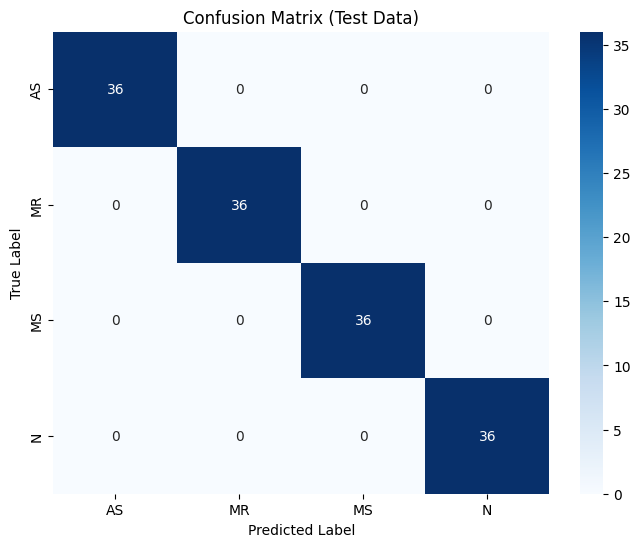

In [36]:
def evaluate_final_predictions(final_predictions, y_test, label_encoder, dataset_name="Test Data"):
    """Evaluates the final predictions (after ensemble averaging)."""

    y_pred = np.argmax(final_predictions, axis=1)  # Get predicted labels
    y_true = np.argmax(y_test, axis=1) # If y_test is one-hot encoded

    print(f"Classification Report ({dataset_name}):")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.show()

    return y_true, y_pred # Return true and predicted labels if needed


# ... (Your model training, prediction, and ensemble averaging code)

# Evaluate the final predictions
y_true_final, y_pred_final = evaluate_final_predictions(final_predictions, y_test_mfcc, label_encoder)

## Incremental

In [4]:
import tensorflow as tf
import numpy as np

class EWC:
    def __init__(self, model, previous_weights, fisher_matrix, lambda_ewc=100.0):
        self.model = model
        self.previous_weights = previous_weights
        self.fisher_matrix = fisher_matrix
        self.lambda_ewc = lambda_ewc

    def ewc_loss(self):
        if self.previous_weights is None or self.fisher_matrix is None:
            return 0.0

        loss = 0.0
        for layer in self.model.layers:
            if layer.name in self.previous_weights and layer.name in self.fisher_matrix:
                if isinstance(layer, tf.keras.layers.Conv2D):
                    delta_w = tf.cast(layer.kernel, tf.float32) - tf.cast(self.previous_weights[layer.name], tf.float32)  # Cast to float32
                    fisher = tf.cast(self.fisher_matrix[layer.name], tf.float32) # Cast to float32
                    loss += self.lambda_ewc * tf.reduce_sum(fisher * delta_w**2)
                elif len(layer.get_weights()) > 0:
                    delta_w = tf.cast(layer.get_weights()[0], tf.float32) - tf.cast(self.previous_weights[layer.name], tf.float32)  # Cast to float32
                    fisher = tf.cast(self.fisher_matrix[layer.name], tf.float32) # Cast to float32
                    loss += self.lambda_ewc * tf.reduce_sum(fisher * delta_w**2)
        return loss

    def compute_fisher(self, X, y):
        num_samples = X.shape[0]
        fisher_matrix = {}

        for layer in self.model.layers:
            if len(layer.get_weights()) > 0:
                if isinstance(layer, tf.keras.layers.Conv2D):
                    fisher_matrix[layer.name] = np.zeros(layer.kernel.shape)
                else:
                    fisher_matrix[layer.name] = np.zeros(layer.get_weights()[0].shape)

        for i in range(num_samples):
            with tf.GradientTape() as tape:
                # Watch the kernel weights directly, converted to Tensors
                watched_vars = []
                for layer in self.model.layers:
                    if isinstance(layer, tf.keras.layers.Conv2D):
                        watched_vars.append(tf.convert_to_tensor(layer.kernel))
                    elif len(layer.get_weights()) > 0:
                        watched_vars.append(tf.convert_to_tensor(layer.get_weights()[0]))
                tape.watch(watched_vars)

                predictions = self.model(np.expand_dims(X[i], axis=0))
                loss = tf.keras.losses.CategoricalCrossentropy()(np.expand_dims(y[i], axis=0), predictions)

            gradients = tape.gradient(loss, watched_vars)

            k = 0
            for layer in self.model.layers:
                if layer.name in fisher_matrix and len(layer.get_weights()) > 0:
                    if gradients[k] is not None:  # Check for None gradients!
                        if isinstance(layer, tf.keras.layers.Conv2D):
                            fisher_matrix[layer.name] += np.square(gradients[k].numpy())
                        else:
                            fisher_matrix[layer.name] += np.square(gradients[k].numpy())
                    k += 1  # Increment k even if gradient is None (to keep indices aligned)

        for layer in self.model.layers:
            if layer.name in fisher_matrix and len(layer.get_weights()) > 0:
                fisher_matrix[layer.name] /= num_samples
        return fisher_matrix

In [5]:
mfcc_bilstm_model = tf.keras.models.load_model("./RedoneModels/mfcc_bilstm.h5")
mfcc_cnn_model = tf.keras.models.load_model("./RedoneModels/mfcc_cnn.h5")
mfcc_lstm_model = tf.keras.models.load_model("./RedoneModels/mfcc_lstm.h5")

spectrogram_mobilenet_model = tf.keras.models.load_model("./RedoneModels/spec_mbnet.h5")
spectrogram_resnet_model = tf.keras.models.load_model("./RedoneModels/spec_resnet.h5")

models = {"mfcc_bilstm":mfcc_bilstm_model, "mfcc_lstm":mfcc_lstm_model, "mfcc_cnn":mfcc_cnn_model, 
          "spectrogram_mobilenet":spectrogram_mobilenet_model, "spectrogram_resnet":spectrogram_resnet_model}

In [6]:
inc_audio_path = "C:/Users/HP/Downloads/Project/Dataset/inc_audio_mfcc_features_with_labels.csv"
new_X_train_mfcc, new_y_train_mfcc, new_X_test_mfcc, new_y_test_mfcc, new_X_train_spec, new_y_train_spec, new_X_test_spec, new_y_test_spec, new_label_encoder, new_datagen = SplitDataset(inc_audio_path)

In [7]:
ewc_objects = {}  # Store EWC objects for each model

for model_name, model in models.items():  # Assuming you have a dictionary of models
    if model_name in ["spectrogram_mobilenet", "spectrogram_resnet"]:
        X_train_task1 = X_train_spec
        y_train_task1 = y_train_spec
    else:
        X_train_task1 = X_train_mfcc
        y_train_task1 = y_train_mfcc

    fisher_matrix = EWC(model, None, None).compute_fisher(X_train_task1, y_train_task1)
    previous_weights = {}

    for layer in model.layers:
        if hasattr(layer, 'get_weights') and len(layer.get_weights()) > 0: # Check if layer has weights
            if isinstance(layer, tf.keras.layers.Conv2D):
                previous_weights[layer.name] = layer.kernel.numpy().astype(np.float32).copy()
            else:
                weights = layer.get_weights()
                if isinstance(weights, list) and len(weights) > 0:  # Check if weights is a list and not empty
                    previous_weights[layer.name] = weights[0].astype(np.float32).copy()

    ewc_objects[model_name] = EWC(model, previous_weights, fisher_matrix)
    print("Completed Task 1 for Model ", model_name)

Completed Task 1 for Model  mfcc_bilstm
Completed Task 1 for Model  mfcc_lstm
Completed Task 1 for Model  mfcc_cnn
Completed Task 1 for Model  spectrogram_mobilenet
Completed Task 1 for Model  spectrogram_resnet


In [8]:
# --- Task 2 (Incremental Learning) ---
# ... (Load or prepare your new data for Task 2: X_train_task2, y_train_task2, X_test_task2, y_test_task2)

for model_name, model in models.items():
    ewc = ewc_objects[model_name]
    optimizer = tf.keras.optimizers.Adam()

    if model_name in ["spectrogram_mobilenet", "spectrogram_resnet"]:
        X_train_task2 = new_X_train_spec  # Use NEW data
        y_train_task2 = new_y_train_spec
        X_test_task2 = new_X_test_spec
        y_test_task2 = new_y_test_spec
    else:
        X_train_task2 = new_X_train_mfcc  # Use NEW data
        y_train_task2 = new_y_train_mfcc
        X_test_task2 = new_X_test_mfcc
        y_test_task2 = new_y_test_mfcc

    for epoch in range(2):  # Adjust number of epochs
        with tf.GradientTape() as tape:
            predictions = model(X_train_task2)
            loss = tf.keras.losses.CategoricalCrossentropy()(y_train_task2, predictions)
            loss += ewc.ewc_loss()
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Evaluate on the new task
    loss, accuracy = model.evaluate(X_test_task2, y_test_task2, verbose=0)
    print(f"Model: {model_name}, Task 2 Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    save_path = f"C:/Users/HP/Downloads/Project/Code/IncrementalUpdatedModels/{model_name}_updated.h5"
    os.makedirs(os.path.dirname(save_path), exist_ok=True) # Create directory if needed
    model.save(save_path)

    # Update previous weights and Fisher matrix
    ewc.previous_weights = {}
    for layer in model.layers:
        if len(layer.get_weights()) > 0:
            if isinstance(layer, tf.keras.layers.Conv2D):
                ewc.previous_weights[layer.name] = layer.kernel.numpy().copy()
            else:
                ewc.previous_weights[layer.name] = layer.get_weights()[0].copy()

    # Compute the new fisher matrix on the new training data
    ewc.fisher_matrix = ewc.compute_fisher(X_train_task2, y_train_task2)

Model: mfcc_bilstm, Task 2 Loss: 1.0559, Accuracy: 0.7292


Model: mfcc_lstm, Task 2 Loss: 0.9712, Accuracy: 0.7500


Model: mfcc_cnn, Task 2 Loss: 0.7571, Accuracy: 0.8854


Model: spectrogram_mobilenet, Task 2 Loss: 0.6817, Accuracy: 0.9479


Model: spectrogram_resnet, Task 2 Loss: 0.6817, Accuracy: 0.9479


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step
Test Accuracy:  0.9375
Classification Report (Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       1.00      0.78      0.88        36
          MS       0.83      0.97      0.90        36
           N       0.97      1.00      0.99        36

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144



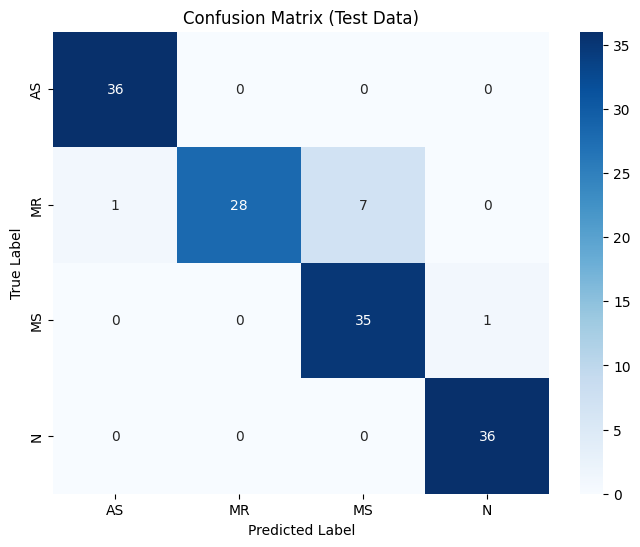

In [13]:
updated_resnet_model = tf.keras.models.load_model("./IncrementalUpdatedModels/spectrogram_resnet_updated.h5")
evaluate_model(updated_resnet_model, X_test_spec, y_test_spec, label_encoder, "Test Data")

In [5]:
import tensorflow as tf
mfcc_bilstm_model = tf.keras.models.load_model("./IncrementalUpdatedModels/mfcc_bilstm_updated.h5")
mfcc_cnn_model = tf.keras.models.load_model("./IncrementalUpdatedModels/mfcc_cnn_updated.h5")
mfcc_lstm_model = tf.keras.models.load_model("./IncrementalUpdatedModels/mfcc_lstm_updated.h5")

spectrogram_mobilenet_model = tf.keras.models.load_model("./IncrementalUpdatedModels/spectrogram_mobilenet_updated.h5")
spectrogram_resnet_model = tf.keras.models.load_model("./IncrementalUpdatedModels/spectrogram_resnet_updated.h5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test Accuracy:  0.9375
Classification Report (MFCC BiLSTM Test Data):
              precision    recall  f1-score   support

          AS       0.95      1.00      0.97        36
          MR       1.00      0.81      0.89        36
          MS       0.85      0.94      0.89        36
           N       0.97      1.00      0.99        36

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144



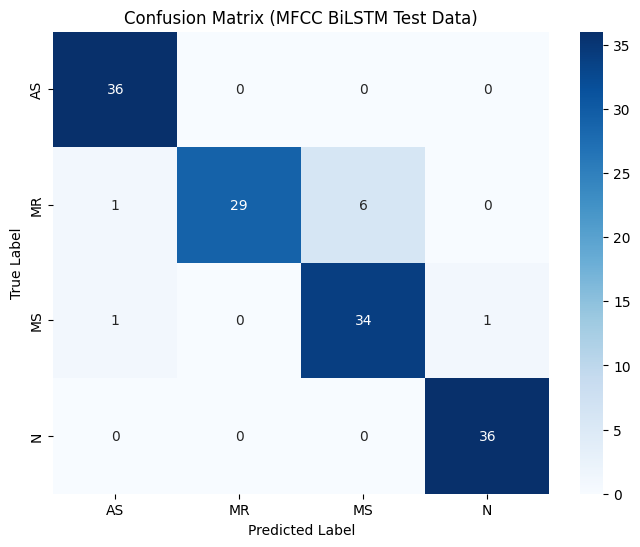

In [9]:
evaluate_model(mfcc_bilstm_model, X_test_mfcc, y_test_mfcc, label_encoder, "MFCC BiLSTM Test Data")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Test Accuracy:  0.9652777777777778
Classification Report (MFCC CNN Test Data):
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        36
          MR       1.00      0.89      0.94        36
          MS       0.90      0.97      0.93        36
           N       0.97      1.00      0.99        36

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



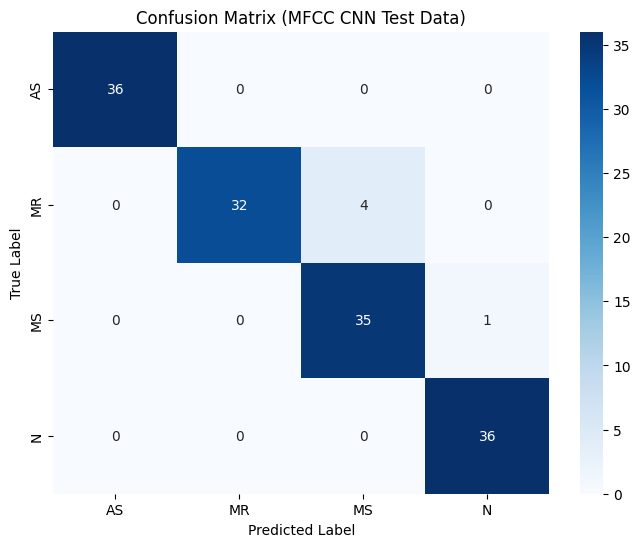

In [10]:
evaluate_model(mfcc_cnn_model, X_test_mfcc, y_test_mfcc, label_encoder, "MFCC CNN Test Data")

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BB1A74EC00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Test Accuracy:  0.9652777777777778
Classification Report (MFCC LSTM Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       0.97      0.92      0.94        36
          MS       0.94      0.94      0.94        36
           N       0.97      1.00      0.99        36

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.96       144
weighted avg       0.97      0.97      0.96       144



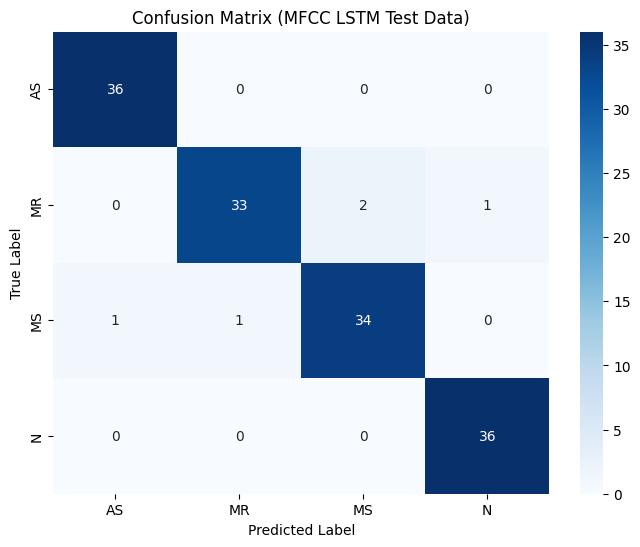

In [11]:
evaluate_model(mfcc_lstm_model, X_test_mfcc, y_test_mfcc, label_encoder, "MFCC LSTM Test Data")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step
Test Accuracy:  0.9375
Classification Report (Spectrogram MBNET Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       1.00      0.78      0.88        36
          MS       0.83      0.97      0.90        36
           N       0.97      1.00      0.99        36

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144



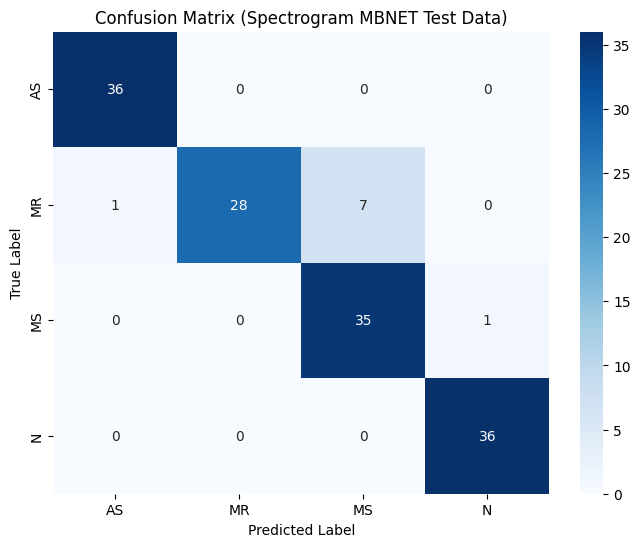

In [13]:
evaluate_model(spectrogram_mobilenet_model, X_test_spec, y_test_spec, label_encoder, "Spectrogram MBNET Test Data")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step
Test Accuracy:  0.9375
Classification Report (Spectrogram ResNet Test Data):
              precision    recall  f1-score   support

          AS       0.97      1.00      0.99        36
          MR       1.00      0.78      0.88        36
          MS       0.83      0.97      0.90        36
           N       0.97      1.00      0.99        36

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144



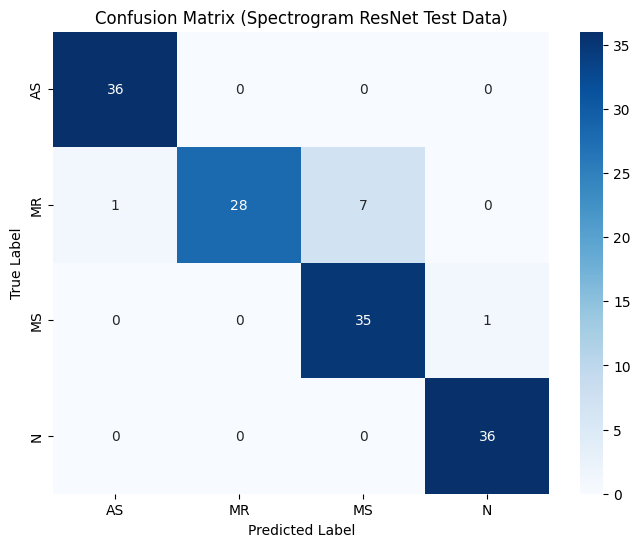

In [14]:
evaluate_model(spectrogram_resnet_model, X_test_spec, y_test_spec, label_encoder, "Spectrogram ResNet Test Data")

In [15]:
df = pd.read_csv(r"C:\Users\HP\Downloads\Project\Dataset\base_audio_mfcc_features_with_labels.csv")

In [19]:
df.iloc[0:5, 3:]

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
0,-303.98373,89.607994,63.180206,49.628277,33.789570,13.866918,8.336157,-0.145857,-4.576695,-6.588324,-5.227671,-3.141516,-1.734284
1,-290.78546,85.328964,63.678967,48.518387,27.950966,13.148191,8.135881,3.857298,-5.930663,-6.506842,-2.847501,-3.514931,-0.673932
2,-300.07132,92.196160,60.428230,46.068400,32.148647,14.977820,9.954712,1.702111,-6.839214,-4.604496,-3.469487,-2.924696,-1.635822
3,-275.96182,82.979480,53.963867,41.477196,30.879040,18.746405,7.151721,0.318052,-3.119924,-5.786453,-4.238536,-3.973494,-2.812032
4,-307.56003,91.761870,61.234344,47.353916,32.499348,20.766950,4.061373,1.760614,-6.531277,-5.492289,-5.298789,-4.180423,-3.422098


## Continuous Method


In [12]:

# Load the CSV file
df_continuous = pd.read_csv(r"C:\Users\HP\Downloads\Project\Dataset\continuous_audio_mfcc_features_with_labels.csv")

# # Display first few rows
# print(df_continuous.head())
# print(df_continuous.info())  # Check for missing values
df_continuous.iloc[0:5, 3:]



,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
0,-512.57367,76.341710,66.315930,51.602673,34.705612,18.286442,4.600972,-4.923218,-9.874365,-10.787354,-8.866605,-5.599062,-2.370692
1,-403.77533,74.965230,45.138332,22.272543,5.168020,-7.319954,-6.140624,-3.651918,-4.219957,0.000051,0.312838,-0.328279,-0.567619
2,-379.20325,70.407290,42.408493,19.306545,5.112959,-2.546124,-9.028151,-4.198436,-1.261936,-0.252304,0.390549,-0.720687,-0.537830
3,-478.29327,83.698990,73.736180,58.959484,41.699596,24.500980,9.617456,-1.394988,-7.900415,-10.182907,-9.244238,-6.467753,-3.244165
4,-480.83330,85.069885,75.247860,60.667503,43.608690,26.557272,11.711545,0.586209,-6.200495,-8.921457,-8.538704,-6.373588,-3.743762


In [27]:
import tensorflow as tf
import numpy as np
import os

class ContinuousEWC:
    def __init__(self, model, lambda_ewc=100.0, fisher_decay=0.9):
        self.model = model
        self.lambda_ewc = lambda_ewc
        self.fisher_decay = fisher_decay  # Decay factor for past knowledge
        self.previous_weights = {}
        self.fisher_matrix = {}

    def compute_fisher(self, X, y):
        """ Compute Fisher information matrix using a streaming approach. """
        num_samples = X.shape[0]
        fisher_matrix = {}

        for layer in self.model.layers:
            if len(layer.get_weights()) > 0:
                fisher_matrix[layer.name] = np.zeros(layer.get_weights()[0].shape)

        for i in range(num_samples):
            with tf.GradientTape() as tape:
                watched_vars = []
                for layer in self.model.layers:
                    if len(layer.get_weights()) > 0:
                        watched_vars.append(tf.convert_to_tensor(layer.get_weights()[0]))
                tape.watch(watched_vars)

                predictions = self.model(np.expand_dims(X[i], axis=0))
                loss = tf.keras.losses.CategoricalCrossentropy()(np.expand_dims(y[i], axis=0), predictions)

            gradients = tape.gradient(loss, watched_vars)

            for j, layer in enumerate(self.model.layers):
                if len(layer.get_weights()) > 0 and gradients[j] is not None:
                    fisher_matrix[layer.name] += np.square(gradients[j].numpy())

        for layer in self.model.layers:
            if layer.name in fisher_matrix:
                fisher_matrix[layer.name] /= num_samples  # Normalize

        return fisher_matrix

    def ewc_loss(self):
        """ Compute the EWC loss to maintain previous knowledge. """
        if not self.previous_weights or not self.fisher_matrix:
            return 0.0

        loss = 0.0
        for layer in self.model.layers:
            if layer.name in self.previous_weights and layer.name in self.fisher_matrix:
                delta_w = tf.cast(layer.get_weights()[0], tf.float32) - tf.cast(self.previous_weights[layer.name], tf.float32)
                fisher = tf.cast(self.fisher_matrix[layer.name], tf.float32)
                loss += self.lambda_ewc * tf.reduce_sum(fisher * delta_w**2)
        return loss

    def update_fisher_matrix(self, X, y):
        """ Update Fisher matrix dynamically with a decay factor for past knowledge. """
        new_fisher_matrix = self.compute_fisher(X, y)

        for layer in self.model.layers:
            if layer.name in new_fisher_matrix:
                if layer.name in self.fisher_matrix:
                    self.fisher_matrix[layer.name] = (self.fisher_decay * self.fisher_matrix[layer.name]) + (1 - self.fisher_decay) * new_fisher_matrix[layer.name]
                else:
                    self.fisher_matrix[layer.name] = new_fisher_matrix[layer.name]

    def save_model_state(self):
        """ Save the current model's weights for knowledge retention. """
        self.previous_weights = {}
        for layer in self.model.layers:
            if len(layer.get_weights()) > 0:
                self.previous_weights[layer.name] = layer.get_weights()[0].copy()

# Load your models
models = {
    "mfcc_bilstm": tf.keras.models.load_model("./RedoneModels/mfcc_bilstm.h5"),
    "mfcc_lstm": tf.keras.models.load_model("./RedoneModels/mfcc_lstm.h5"),
    "mfcc_cnn": tf.keras.models.load_model("./RedoneModels/mfcc_cnn.h5"),
    "spectrogram_mobilenet": tf.keras.models.load_model("./RedoneModels/spec_mbnet.h5"),
    "spectrogram_resnet": tf.keras.models.load_model("./RedoneModels/spec_resnet.h5")
}

# Load new data
inc_audio_path = r"C:\Users\HP\Downloads\Project\Dataset\continuous_audio_mfcc_features_with_labels.csv"
new_X_train_mfcc, new_y_train_mfcc, new_X_test_mfcc, new_y_test_mfcc, new_X_train_spec, new_y_train_spec, new_X_test_spec, new_y_test_spec, new_label_encoder, new_datagen = SplitDataset(inc_audio_path)

# Initialize continuous learning objects
continuous_ewc_objects = {model_name: ContinuousEWC(model) for model_name, model in models.items()}

# Continuous Training Loop (Simulating a stream of incoming data)
num_updates = 5  # Number of continuous updates (simulate streaming)
batch_size = 32  # Mini-batch size for updates

for update in range(num_updates):
    print(f"\n===== Continuous Learning Update {update+1} =====")

    for model_name, model in models.items():
        ewc = continuous_ewc_objects[model_name]
        optimizer = tf.keras.optimizers.Adam()

        if model_name in ["spectrogram_mobilenet", "spectrogram_resnet"]:
            X_train_stream, y_train_stream = new_X_train_spec, new_y_train_spec
            X_test_stream, y_test_stream = new_X_test_spec, new_y_test_spec
        else:
            X_train_stream, y_train_stream = new_X_train_mfcc, new_y_train_mfcc
            X_test_stream, y_test_stream = new_X_test_mfcc, new_y_test_mfcc

        # Detect number of classes dynamically
        num_classes = len(np.unique(y_train_stream))

        # Select appropriate loss function
        if num_classes > 1:
            loss_fn = tf.keras.losses.CategoricalCrossentropy()
        else:
            loss_fn = tf.keras.losses.BinaryCrossentropy()

        dataset = tf.data.Dataset.from_tensor_slices((X_train_stream, y_train_stream)).shuffle(len(X_train_stream)).batch(batch_size)

        for epoch in range(2):  # Adapt based on available data
            for batch_X, batch_y in dataset:
                with tf.GradientTape() as tape:
                    predictions = model(batch_X)

                    # Convert labels correctly
                    if num_classes > 1:
                        batch_y = tf.one_hot(tf.cast(batch_y, tf.int32), depth=num_classes)
                    else:
                        # Convert batch_y to correct format
                        batch_y = tf.cast(batch_y, tf.int32)  # Ensure integer labels
                        loss = loss_fn(batch_y, predictions) + ewc.ewc_loss()


                    batch_y_one_hot = tf.one_hot(tf.cast(batch_y, tf.int32), depth=4)  # Assuming 4 classes
                    loss = tf.keras.losses.CategoricalCrossentropy()(batch_y_one_hot, predictions)


                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Evaluate model after each stream update
        loss, accuracy = model.evaluate(X_test_stream, y_test_stream, verbose=0)
        print(f"Model: {model_name}, Update {update+1} Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

        # Save updated model
        save_path = f"C:/Users/HP/Downloads/Project/Code/ContinuousUpdatedModels/{model_name}_updated.h5"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        model.save(save_path)

        # Update Fisher matrix dynamically
        ewc.update_fisher_matrix(X_train_stream, y_train_stream)
        ewc.save_model_state()

# Final Evaluation
print("\n==== Final Evaluation ====")
for model_name, model in models.items():
    model_path = f"./ContinuousUpdatedModels/{model_name}_updated.h5"
    updated_model = tf.keras.models.load_model(model_path)

    if model_name in ["spectrogram_mobilenet", "spectrogram_resnet"]:
        X_test_final, y_test_final = new_X_test_spec, new_y_test_spec
    else:
        X_test_final, y_test_final = new_X_test_mfcc, new_y_test_mfcc

    loss, accuracy = updated_model.evaluate(X_test_final, y_test_final, verbose=0)
    print(f"Final Model: {model_name}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.

===== Continuous Learning Update 1 =====


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(32, 1), output.shape=(32, 4)